#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Наша задача - построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

In [1]:
#импортируем библиотеки
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.stattools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error as mse

import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
data = pd.read_csv('/taxi.csv', index_col=[0], parse_dates=[0]) #загружаем данные
data.sort_index(inplace=True)
data = data.resample('1H').sum() #resample по 1 часу
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

In [3]:
data.shape

(4416, 1)

In [4]:
data.index.max()

Timestamp('2018-08-31 23:00:00', freq='H')

У нас представлены 4416 значений количества заказов такси за каждый час с 2018-03-01 00:00:00 по 2018-08-31 23:00:00. 

Попробуем выявить сезонность. Будем рассматривать более поздние данные.

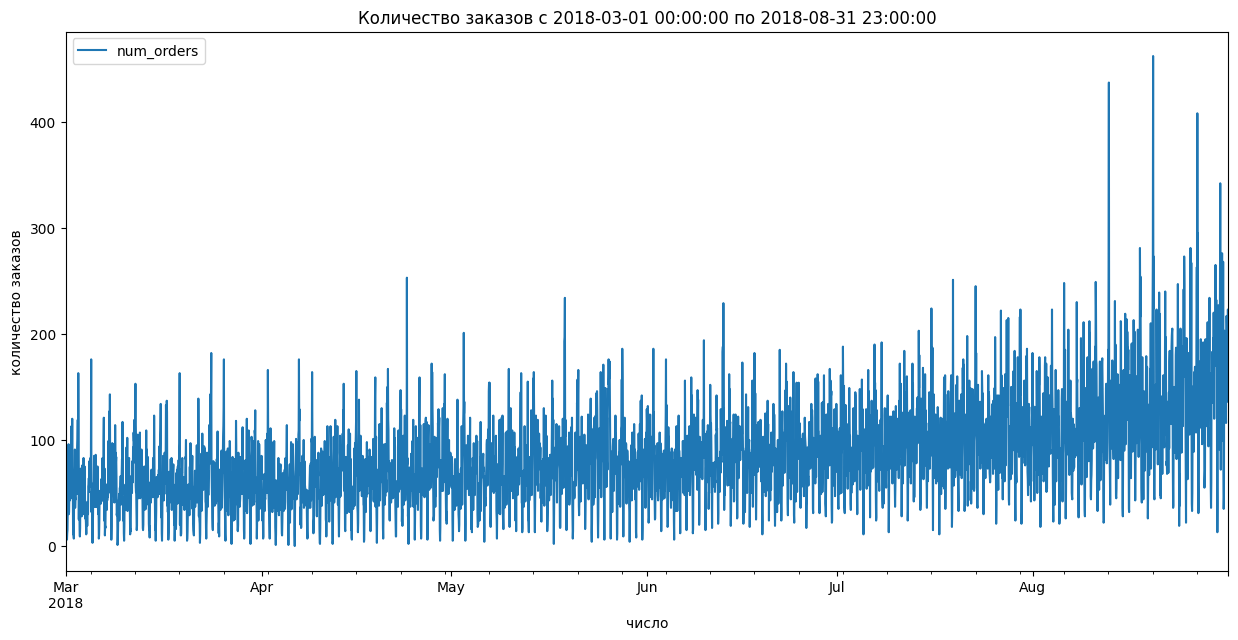

In [5]:
data.plot(figsize=(15,7), xlabel='число', ylabel='количество заказов',
               title='Количество заказов с 2018-03-01 00:00:00 по 2018-08-31 23:00:00');

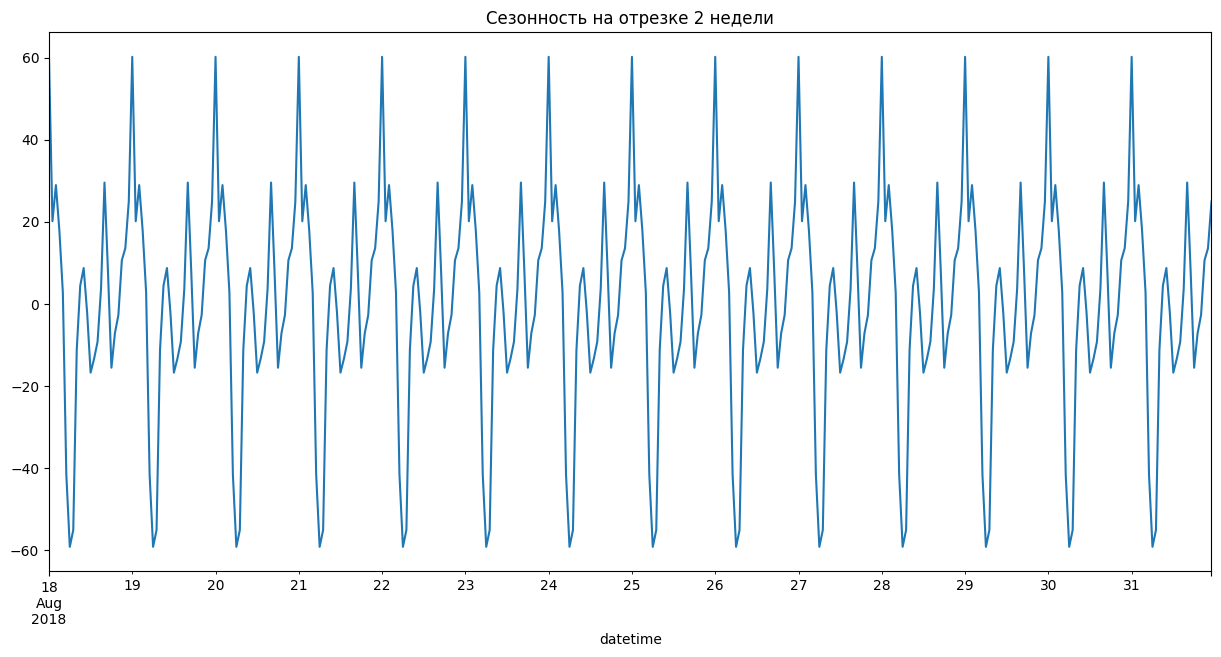

In [6]:
decomposed = seasonal_decompose(data)
decomposed.seasonal['2018-08-18 00:00':'2018-08-31 23:00'].plot(figsize=(15,7),
                                                                title='Сезонность на отрезке 2 недели');

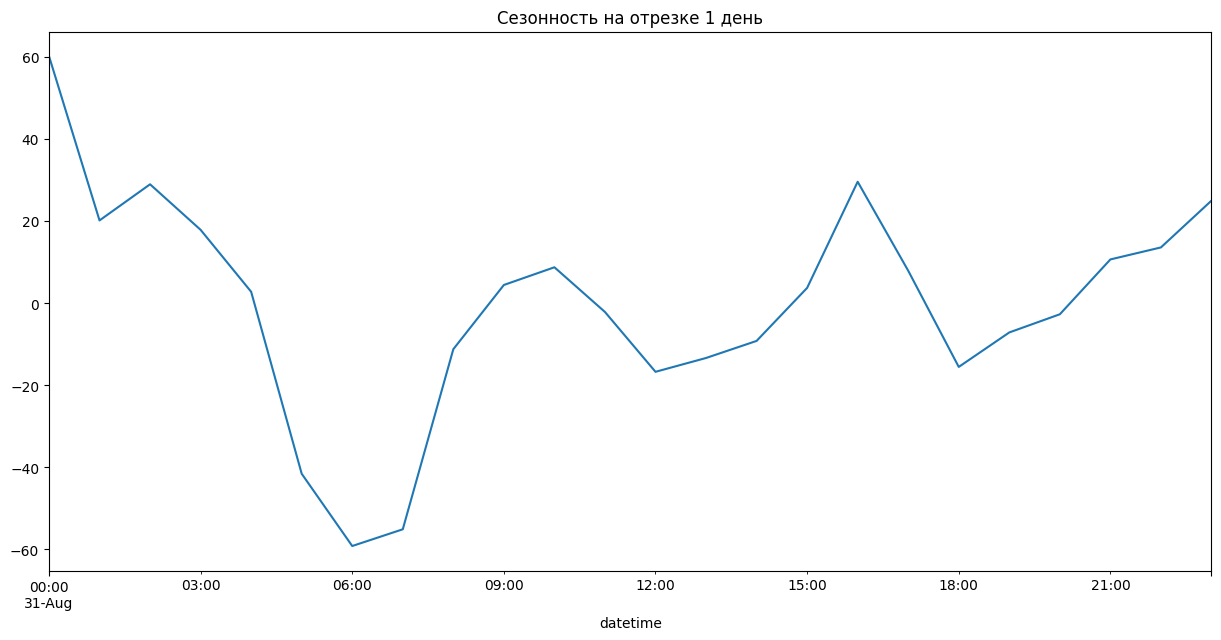

In [7]:
decomposed.seasonal['2018-08-31 00:00':'2018-08-31 23:00'].plot(figsize=(15,7),
                                                                title='Сезонность на отрезке 1 день');

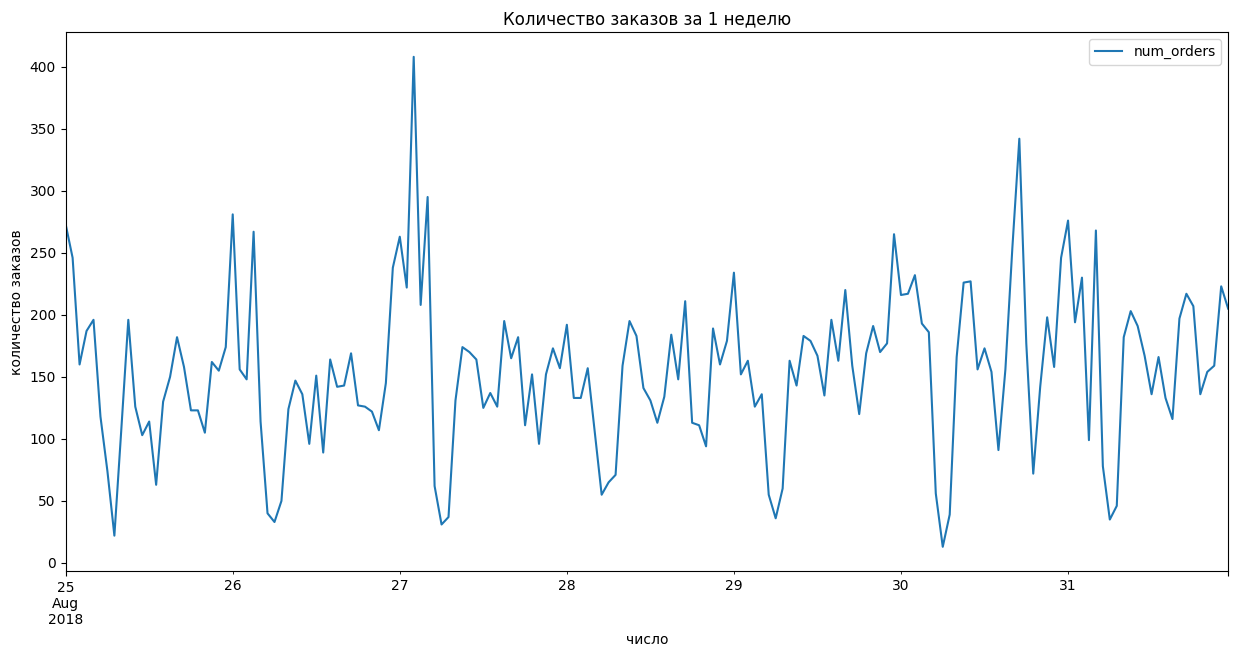

In [8]:
data['2018-08-25':'2018-08-31'].plot(figsize=(15,7), xlabel='число', ylabel='количество заказов',
               title='Количество заказов за 1 неделю'); #неделя

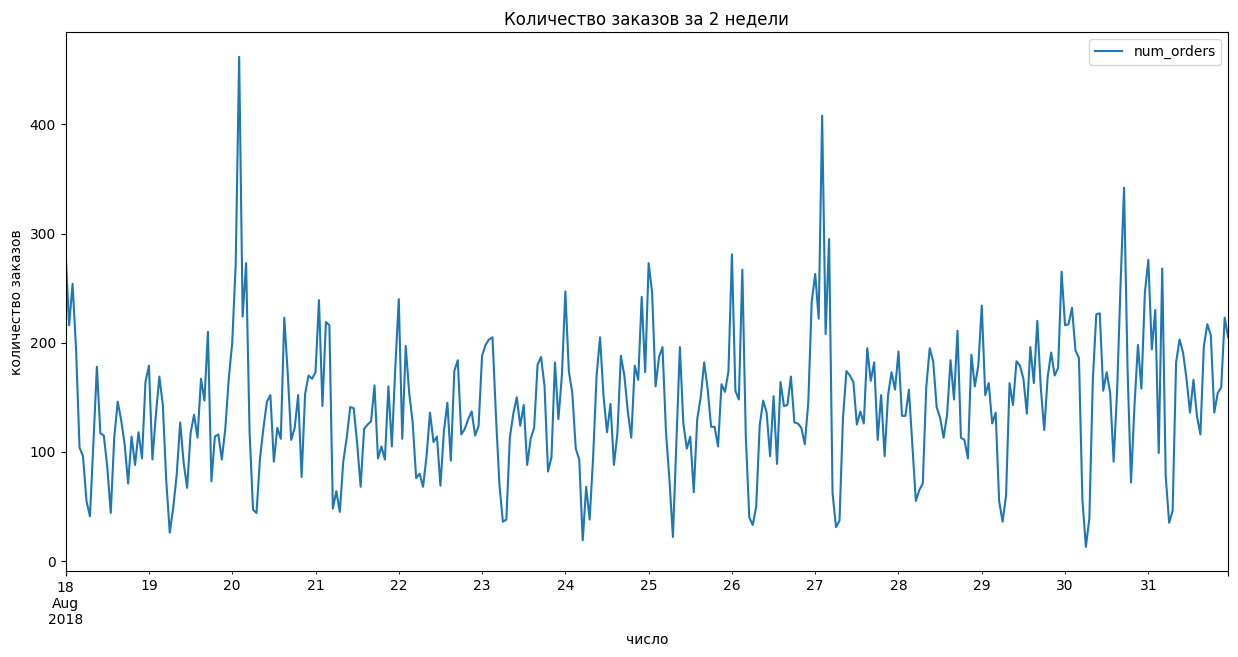

In [9]:
data['2018-08-18':'2018-08-31'].plot(figsize=(15,7), xlabel='число', ylabel='количество заказов',
               title='Количество заказов за 2 недели'); #2 недели

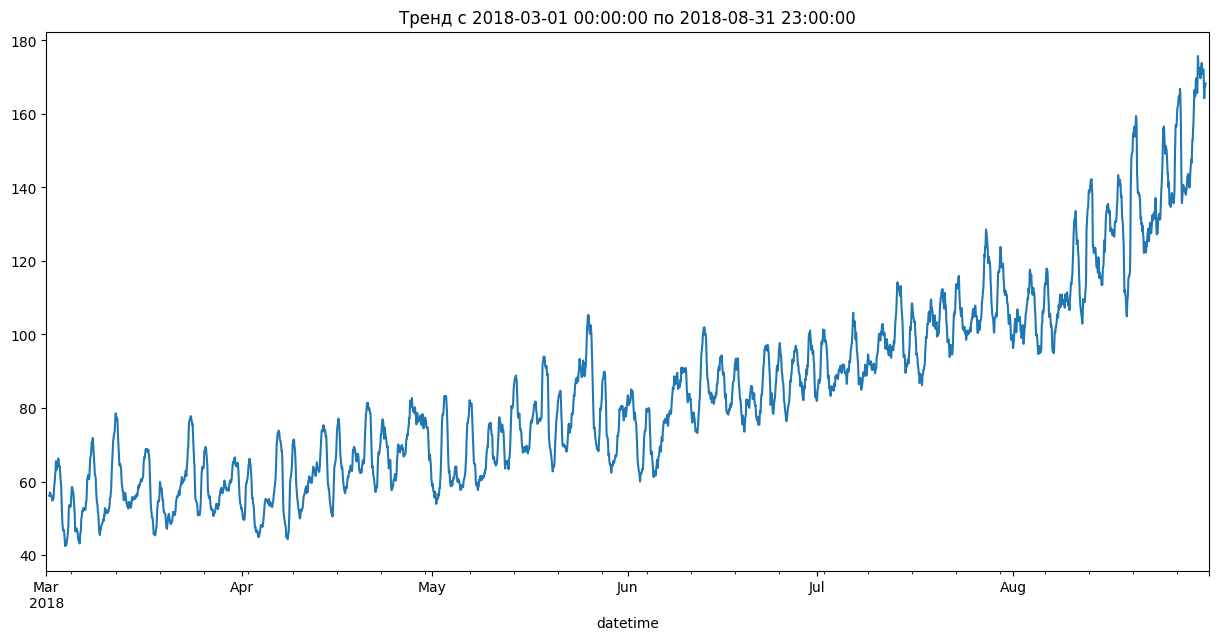

In [10]:
decomposed.trend.plot(figsize=(15,7),
               title='Тренд с 2018-03-01 00:00:00 по 2018-08-31 23:00:00');

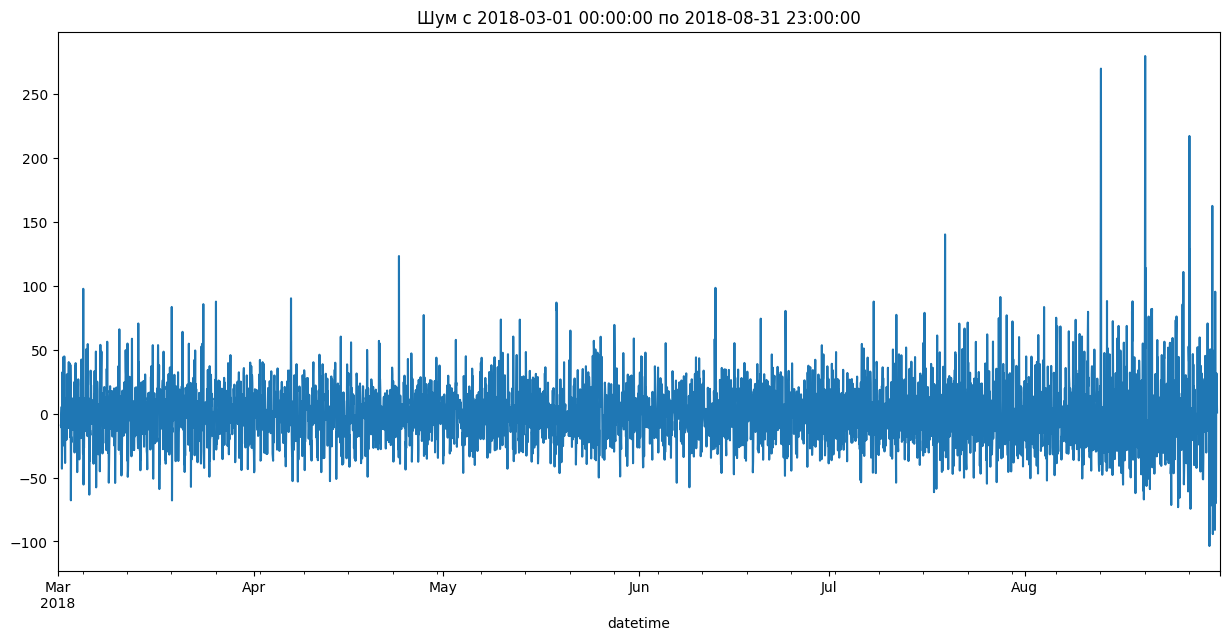

In [11]:
decomposed.resid.plot(figsize=(15,7),
               title='Шум с 2018-03-01 00:00:00 по 2018-08-31 23:00:00');

По графикам можно сделат выводы:
- Есть суточная сезонность. Резкий рост числа заказов ночью, затем спад к 6 утра, после рост к 9 утра и небольшие колебания в течение дня.
- Можно сделать предположение о недельной сезонности, не она менее выражена.
- Заметен общий тренд на рост количества заказов. Видно, что с началом лета скорость роста увеличилась.
- Остатки постоянны на всем времени, но к концу выборки есть выбросы. Значит, в конце периода есть данные, которые сложнее прогнозировать.

Применим тест Дики-Фуллера для оценки стационарности ряда.

Н0: ряд не стационарен
Н1: ряд стационарен
Уровень значимости 5%

In [12]:
statsmodels.tsa.stattools.adfuller(data)

(-3.068924289027951,
 0.028940051402613316,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

p-value ниже 5%, поэтому отвергаем нулевую теорию. Ряд стационарен.

## Обучение

**Добавление признаков**

In [13]:
def make_features(data, max_lag, rolling_mean_size): #функция добавления признаков
    date_copy = data.copy()
    date_copy['hour'] = date_copy.index.hour
    date_copy['dayofweek'] = date_copy.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        date_copy['lag_{}'.format(lag)] = date_copy['num_orders'].shift(lag)

    date_copy['rolling_mean'] = date_copy['num_orders'].shift().rolling(rolling_mean_size).mean()

    return date_copy

In [14]:
data_new = make_features(data, 24, 168) #добавление признаков

Выявленная суточная сезонность показывает, что на прогноз влияют значения за последние 24 часа, поэтому добавим в признаки 24 предыдущих значения. 

Добавим час и день недели, т.к. от них наблюдается зависимость количества заказов.

Скользящее среднее задает общий тренд временного ряда. Возьмем значение равное неделе.

**Подготовка к обучению**

In [15]:
train_valid, test = train_test_split(data_new, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
X_valid = valid.drop(['num_orders'], axis = 1)
y_valid = valid['num_orders']
X_test = test.drop(['num_orders'], axis = 1)
y_test = test['num_orders']

**LinearRegression**

In [16]:
model_lr = LinearRegression(n_jobs=-1).fit(X_train, y_train)
y_pred = model_lr.predict(X_valid)
print("RMSE", mse(y_valid, y_pred, squared=False))

RMSE 34.00164975551271


Обучили модель линейной регрессии, получили RMSE 34.

**LigthGBM**

Обучим LightGBM, подберем лучшие параметры с помощью цикла.

In [17]:
best_lgbm = LGBMRegressor(verbose=-1).fit(X_train, y_train)
y_pred = best_lgbm.predict(X_valid)
best_RMSE = mse(y_valid, y_pred, squared=False)
best_RMSE

29.940201590726655

In [18]:
best_m = 0
best_d = 0

for m in range(50,121,10):
    for d in range(8,15):
        lgbm = LGBMRegressor(n_estimators = m, max_depth=d, verbose=-1).fit(X_train, y_train)
        y_pred = lgbm.predict(X_valid)
        rmse = mse(y_valid, y_pred, squared=False) 
        if rmse < best_RMSE:
            best_lgbm = lgbm
            best_RMSE = rmse
            best_m = m
            best_d = d
            
print('n_estimators ', best_m, '\nmax_depth ', best_d, '\nRMSE', best_RMSE)

n_estimators  100 
max_depth  9 
RMSE 29.739974318703805


Получили, что лучшая модель LGBM с параметрими n_estimators=100, max_depth=9 дает RMSE=29.74.

## Тестирование

Проверим работу лучшей модели на тестовой выборке.

In [19]:
y_pred = best_lgbm.predict(X_test)
mse(y_test, y_pred, squared=False)

46.80833863254793

Получили RMSE=46.8. Это удовлетворяем условиям задачи.

Мы видим значительную разницу между метриками на валидационной и тестовой выборках. Это происходит из-за того, что в тестовую выборку попали менее предсказуемые данные, как мы увидели при анализе остатков.

**Вывод**

Мы изучили исторические данные, выявили сезонность и тренд, добавили новые признаки и обучили несколько моделей. Получили лучшую модель - LigthGBM с параметрими n_estimators=100, max_depth=9, которая выдает метрику RMSE = 46.8 на тестовой выборке.